# Welcome to *The Christmas Card Conundrum*! #

Each year Kaggle hosts a special Santa-themed optimization challenge. This year you're challenged to optimize the path of a robotic arm over the points of an image, minimizing both the movement of the arm and the change in color from step to step.

This notebook introduces the problem and defines a number of convenience functions you might find useful. We also look at the problem's "configuration space", which might provide a more natural setting for optimization. Finally, we create a simple baseline submission.

In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from functools import *
from itertools import *
from pathlib import Path
from PIL import Image

plt.style.use('seaborn-whitegrid')

data_dir = Path('./data')

# The Image #

The `image.csv` file contains the canonical color values for the image as well as their respective Cartesian coordinates. (Instead of array indicies, we use Cartesian coordinates to refer to points in the image, with the center of the image at `(0, 0)`.) This file is what you should use when computing the score for your solution. It's the same file that the official scoring function uses.

In [4]:
df_image = pd.read_csv(data_dir / 'image.csv')

df_image

,x,y,r,g,b
0,-128,128,0.60,0.62,0.65
1,-127,128,0.72,0.74,0.79
2,-126,128,0.71,0.73,0.78
3,-125,128,0.71,0.73,0.78
4,-124,128,0.71,0.74,0.78
...,...,...,...,...,...
66044,124,-128,0.43,0.60,0.87
66045,125,-128,0.43,0.60,0.87
66046,126,-128,0.43,0.60,0.87
66047,127,-128,0.43,0.60,0.88


Here we'll define some convenience functions to transform the image between various formats and then transform the dataframe into a numpy array.

In [5]:
# Functions to map between cartesian coordinates and array indexes
def cartesian_to_array(x, y, shape):
    m, n = shape[:2]
    i = (n - 1) // 2 - y
    j = (n - 1) // 2 + x
    if i < 0 or i >= m or j < 0 or j >= n:
        raise ValueError("Coordinates not within given dimensions.")
    return i, j


def array_to_cartesian(i, j, shape):
    m, n = shape[:2]
    if i < 0 or i >= m or j < 0 or j >= n:
        raise ValueError("Coordinates not within given dimensions.")
    y = (n - 1) // 2 - i
    x = j - (n - 1) // 2
    return x, y


point = (1, 8)
shape = (9, 9, 3)
assert cartesian_to_array(*array_to_cartesian(*point, shape), shape) == point


# Functions to map an image between array and record formats
def image_to_dict(image):
    image = np.atleast_3d(image)
    kv_image = {}
    for i, j in product(range(len(image)), repeat=2):
        kv_image[array_to_cartesian(i, j, image.shape)] = tuple(image[i, j])
    return kv_image


def image_to_df(image):
    return pd.DataFrame(
        [(x, y, r, g, b) for (x, y), (r, g, b) in image_to_dict(image).items()],
        columns=['x', 'y', 'r', 'g', 'b']
    )


def df_to_image(df):
    side = int(len(df) ** 0.5)  # assumes a square image
    return df.set_index(['x', 'y']).to_numpy().reshape(side, side, -1)

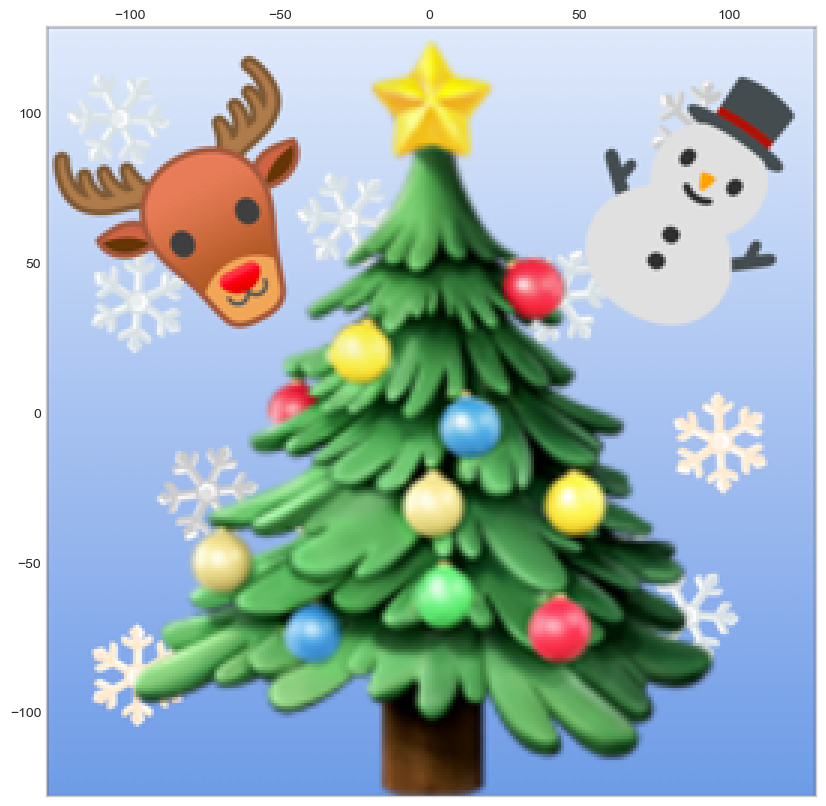

In [6]:
image = df_to_image(df_image)
assert image_to_df(image).equals(df_image)  # ensure transforms are inverses

radius = 128
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(image, extent=(-radius, radius+1, -radius, radius+1))
ax.grid(None);

# The Robotic Arm #

The robotic arm has eight links of length 64, 32, 16, 8, 4, 2, 1, and 1 connected at joints like so:

In [7]:
def plot_configuration(config, image=None, ax=None, color='0.25', **figure_args):
    def get_position(config):
        return reduce(lambda p, q: (p[0] + q[0], p[1] + q[1]), config, (0, 0))

    if ax is None:
        _, ax = plt.subplots(**figure_args)

    k = 2 ** (len(config) - 1) + 1
    X, Y = (np.vstack([[(0, 0)], np.asarray(config).cumsum(axis=0)])[:-1].T - 0.5)
    U, V = np.asarray(config).T
    ax.quiver(
        X, Y, U, V,
        angles='xy', scale_units='xy', scale=1,
        color=color,
        width=0.005,
        zorder=10,
    )
    point = get_position(config)
    ax.plot(point[0]-0.5, point[1]-0.5, '.', color='k', zorder=11)
    if image is not None:
        ax.matshow(image, extent=[-k-1, k, -k-1, k])
    ax.set_xlim(-k-1, k)
    ax.set_ylim(-k-1, k)
    ax.set_aspect('equal')
    ax.set_xticks(np.arange(-k, k+1))
    ax.set_yticks(np.arange(-k, k+1))
    return ax

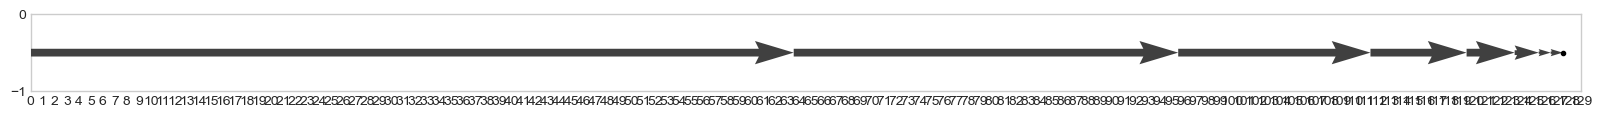

In [8]:
ax = plot_configuration([(64, 0), (32, 0), (16, 0), (8, 0), (4, 0), (2, 0), (1, 0), (1, 0)], figsize=(20, 1))
ax.set_xlim(0, radius+1)
ax.set_ylim(-1, 0)
ax.grid(None)
ax.set_aspect('auto')

In [24]:
r = np.array([64, 32, 16, 8, 4, 2, 1, 1])

r * 8

array([512, 256, 128,  64,  32,  16,   8,   8])

We'll use arms with fewer links for most of the examples to simplify the presentation, however. Here's an arm with links of length 2, 1, and 1.

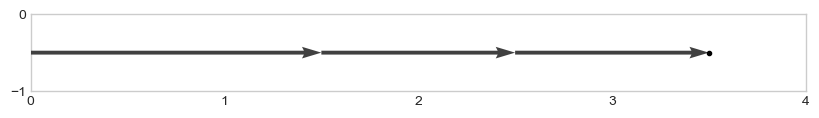

In [9]:
ax = plot_configuration([(2, 0), (1, 0), (1, 0)], figsize=(10, 1))
ax.set_xlim(0, 4)
ax.set_ylim(-1, 0)
ax.grid([])
ax.set_aspect('auto')

We describe the **configuration** of the arm by giving the displacement vector of each link oriented at its joint. The first link (the longest one) is oriented at the point $(0, 0)$, so we can get the **position** of the arm by summing up the displacement vectors.

Here's an example with a four-link arm.

In [10]:
def get_position(config):
    return reduce(lambda p, q: (p[0] + q[0], p[1] + q[1]), config, (0, 0))


# The configuration of a 4-link arm descibed by a list of displacement vectors. 
config = [(4, 0), (-2, 2), (-1, 0), (-1, 1)]

get_position(config)

(0, 3)

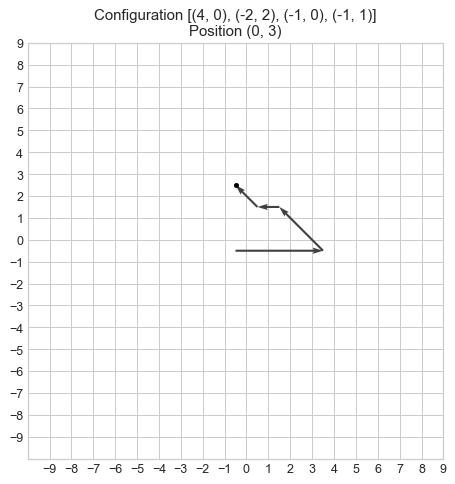

In [11]:
ax = plot_configuration(config, figsize=(6, 6), dpi=90)
ax.set_title(f"Configuration {config}\nPosition {get_position(config)}");

A link of length $l$ with displacement vector $(x, y)$ must satisfy the condition $\max\left(\mid x \mid, \mid y \mid\right)=l$. (This condition essentially defines what it means for a link to have length $l$.) The links, in other words, travel around the perimeter of a square with sides of length $2l$.

In [12]:
def rotate_link(vector, direction):
    x, y = vector
    if direction == 1:  # counter-clockwise
        if y >= x and y > -x:
            x -= 1
        elif y > x and y <= -x:
            y -= 1
        elif y <= x and y < -x:
            x += 1
        else:
            y += 1
    elif direction == -1:  # clockwise
        if y > x and y >= -x:
            x += 1
        elif y >= x and y < -x:
            y += 1
        elif y < x and y <= -x:
            x -= 1
        else:
            y -= 1
    return (x, y)


def rotate(config, i, direction):
    config = config.copy()
    config[i] = rotate_link(config[i], direction)
    return config


def get_square(link_length):
    link = (link_length, 0)
    coords = [link]
    for _ in range(8 * link_length - 1):
        link = rotate_link(link, direction=1)
        coords.append(link)
    return coords

In addition, the vectors must be integer valued, so there are $8l$ possible values for a vector of length $l$.

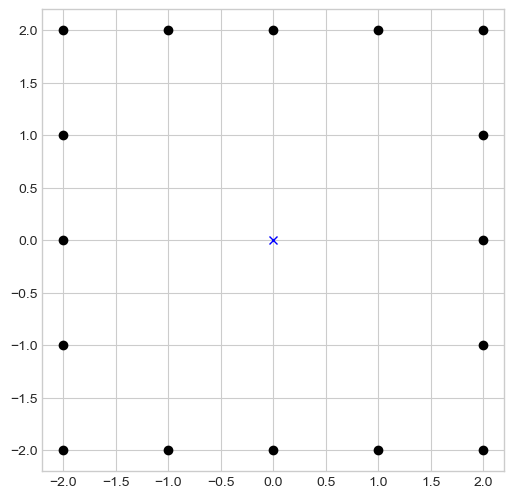

In [13]:
link_length = 2
square = np.asarray(get_square(link_length))
fig, ax = plt.subplots()
ax.plot(square[:, 0], square[:, 1], 'ok')
ax.plot([0], [0], 'xb')
ax.set_aspect('equal');

Here we can see the second link (with length 2) making a complete rotation around all 16 of its possible directions.

In [14]:
for _ in range(16):
    print(config)
    config = rotate(config, 1, direction=1)

[(4, 0), (-2, 2), (-1, 0), (-1, 1)]
[(4, 0), (-2, 1), (-1, 0), (-1, 1)]
[(4, 0), (-2, 0), (-1, 0), (-1, 1)]
[(4, 0), (-2, -1), (-1, 0), (-1, 1)]
[(4, 0), (-2, -2), (-1, 0), (-1, 1)]
[(4, 0), (-1, -2), (-1, 0), (-1, 1)]
[(4, 0), (0, -2), (-1, 0), (-1, 1)]
[(4, 0), (1, -2), (-1, 0), (-1, 1)]
[(4, 0), (2, -2), (-1, 0), (-1, 1)]
[(4, 0), (2, -1), (-1, 0), (-1, 1)]
[(4, 0), (2, 0), (-1, 0), (-1, 1)]
[(4, 0), (2, 1), (-1, 0), (-1, 1)]
[(4, 0), (2, 2), (-1, 0), (-1, 1)]
[(4, 0), (1, 2), (-1, 0), (-1, 1)]
[(4, 0), (0, 2), (-1, 0), (-1, 1)]
[(4, 0), (-1, 2), (-1, 0), (-1, 1)]


The design of the arm allows it to reach any position within a $(2L + 1) \times (2L + 1)$ image, where $L$ is the total length of the arm (the sum of the link lengths). The 8-link arm has a length of 128, so it can reach any position in a $257 \times 257$ image.

### Changing the Configuration ###

We can move the position of the arm over the image by changing its configuration step-by-step. At each step, we may rotate each link of the arm either counter-clockwise or clockwise (or keep it the same). The **neighbors** of a configuration are those configurations that can be reached from it in a single step.

In [15]:
def get_neighbors(config):
    nhbrs = (
        reduce(lambda x, y: rotate(x, *y), enumerate(directions), config)
        for directions in product((-1, 0, 1), repeat=len(config))
    )
    return list(filter(lambda c: c != config, nhbrs))

In [16]:
neighbors = get_neighbors(config)

len(neighbors)

80

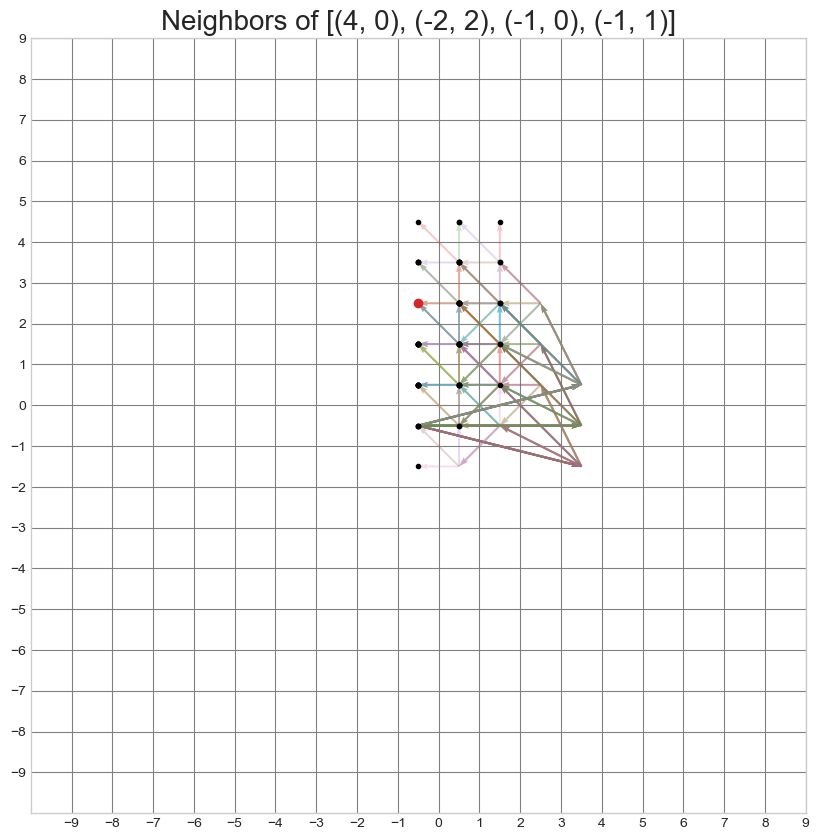

In [17]:
point = (0, 0)
cs = neighbors
k = 2 ** (len(config) - 1) + 1
colors = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

fig, ax = plt.subplots(figsize=(10, 11))
for c in cs:
    X, Y = (np.vstack([[(0, 0)], np.asarray(c).cumsum(axis=0)])[:-1].T - 0.5)
    U, V = np.asarray(c).T
    ax.quiver(
        X, Y, U, V,
        angles='xy', scale_units='xy', scale=1,
        color=next(colors),
        width=0.0025,
        zorder=10,
        alpha=0.25,
    )
    point = get_position(c)
    ax.plot(point[0]-0.5, point[1]-0.5, '.', color='k', zorder=11)
point = get_position(config)
ax.plot(point[0]-0.5, point[1]-0.5, 'o', color='C3', zorder=11)
ax.set_xlim(-k-1, k)
ax.set_ylim(-k-1, k)
ax.set_aspect('equal')
ax.set_xticks(np.arange(-k, k+1))
ax.set_yticks(np.arange(-k, k+1))
ax.grid(True, color='0.5')
ax.set_title(f"Neighbors of {config}", fontsize=20);

Note that there will typically be many more neighboring *configurations* (lists of vectors) than neighboring *positions* (points in the image, the sum of the vectors), since each position can typically be reached by many configurations.

In the figure above, the starting configuration is positioned at the red point. It can reach any of the other indicated positions in a single step (though at varying costs, as we will see).

# The Cost Function #

The goal of the competition is to create a sequence of configurations reaching every point in the image while minimizing both a *reconfiguration cost* and a *color cost*. The starting configuration must be `[(64, 0), (-32, 0), (-16, 0), (-8, 0), (-4, 0), (-2, 0), (-1, 0), (-1, 0)]`, which is positioned at the point `(0, 0)` in the image.

The **reconfiguration cost** at each step is the square root of the number of links rotated at that step, while the **color cost** is the sum of the absolute change in the color components from the previous step's position to the current position multiplied by a scaling constant. The total cost at each step is the sum of the reconfiguration cost and the color cost.

In [18]:
# Functions to compute the cost function

# Cost of reconfiguring the robotic arm: the square root of the number of links rotated
def reconfiguration_cost(from_config, to_config):
    nlinks = len(from_config)
    diffs = np.abs(np.asarray(from_config) - np.asarray(to_config)).sum(axis=1)
    return np.sqrt(diffs.sum())


# Cost of moving from one color to another: the sum of the absolute change in color components
def color_cost(from_position, to_position, image, color_scale=3.0):
    return np.abs(image[to_position] - image[from_position]).sum() * color_scale


# Total cost of one step: the reconfiguration cost plus the color cost
def step_cost(from_config, to_config, image):
    from_position = cartesian_to_array(*get_position(from_config), image.shape)
    to_position = cartesian_to_array(*get_position(to_config), image.shape)
    return (
        reconfiguration_cost(from_config, to_config) +
        color_cost(from_position, to_position, image)
    )

We'll see some examples of computing the cost of a path below.

# The Configuration Space #

We can take an alternative view of the optimization problem to make it similar to a traditional Traveling Salesman Problem.

In a single step, any of the links in the arm can transition to either of two states by a counter-clockwise rotation or a clockwise rotation. Laying out the transitions for each link along perpendicular axes, we form the **configuration space** of the arm. In general, an arm with $N$ links will create a configuration space with $N$ dimensions. Each unique configuration will occupy a point in a lattice (or grid) in this space. Filling in this lattice gives us a *cubical complex*, a bunch of cubes pasted together on their faces.

The configuration space for a 2-link arm is just a grid of squares, as the following figures show.

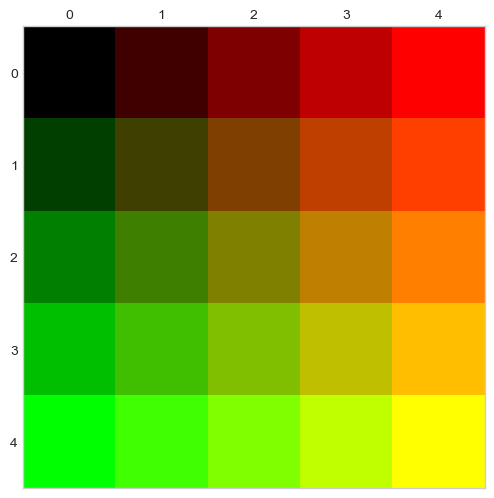

In [19]:
# Create an artificial test image
config = [(1, 0), (-1, 0)]
neighbors = get_neighbors(config)

side = 5
image = np.zeros((side, side, 3))
image[:, :, 0] = np.linspace(0, 1, side)
image[:, :, 1] = np.linspace(0, 1, side).reshape(-1, 1)
fig, ax = plt.subplots()
ax.matshow(image)
ax.grid([]);

In the image we created above, each position has a unique color. We map these into the configuration space of the 2-link arm below.

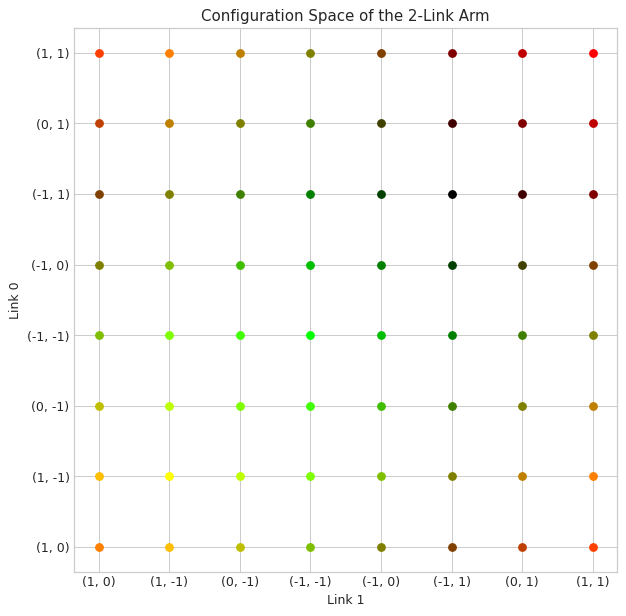

In [18]:
square = [(1, 0)]
for _ in range(7):
    square.append(rotate(square, -1, direction=-1)[-1])
configurations = list(product(square, repeat=2))

fig, ax = plt.subplots(figsize=(8, 8), dpi=90)
cspace = np.zeros((len(square), len(square), 3))
for i, x in enumerate(square):
    for j, y in enumerate(square):
        cspace[i, j] = image[cartesian_to_array(*get_position([x, y]), image.shape)]
        ax.plot([i], [j], 'o', color=cspace[i, j])
ax.set_aspect('equal')
ax.set_xlabel('Link 1')
ax.set_xticks(range(len(square)))
ax.set_xticklabels(square)
ax.set_ylabel('Link 0')
ax.set_yticks(range(len(square)))
ax.set_yticklabels(square)
ax.set_title("Configuration Space of the 2-Link Arm");

A movement in the positive direction (right/up) indicates a counter-clockwise rotation, while a movement in the negative direction (left/down) indicates a clockwise rotation. Moving across the *diagonal* of a square means a rotation of both links in a single step. The reconfiguration cost is simply the ordinary Euclidean distance in this space: $1$ for a step across the edge of a square, $\sqrt{2}$ for a step across a diagonal. So we could think about the Santa optimization problem as being like a shortest path problem in the configuration space. (Note however that we don't need to visit *every* point in the configuration space, just some set of points corresponding to unique positions in the image.)


For more on configuration spaces, you might enjoy this article: [Ghrist, R., & Peterson, V. (2007). The geometry and topology of reconfiguration.](https://scholar.google.com/scholar?cluster=7705042403448786239&hl=en&as_sdt=0,37).

# A Simple Solution #

Now let's use what we know to create a simple solution to this problem. Our stategy will be to write a function that can create a sequence of configurations with a given initial configuration that terminates at a desired position.

In [19]:
def get_direction(u, v):
    """Returns the sign of the angle from u to v."""
    direction = np.sign(np.cross(u, v))
    if direction == 0 and np.dot(u, v) < 0:
        direction = 1
    return direction


# We don't use this elsewhere, but you might find it useful."""
def get_angle(u, v):
    """Returns the angle (in degrees) from u to v."""
    return np.degrees(np.math.atan2(
        np.cross(u, v),
        np.dot(u, v),
    ))


def get_path_to_point(config, point):
    """Find a path of configurations to `point` starting at `config`."""
    path = [config]
    # Rotate each link, starting with the largest, until the point can
    # be reached by the remaining links. The last link must reach the
    # point itself.
    for i in range(len(config)):
        link = config[i]
        base = get_position(config[:i])
        relbase = (point[0] - base[0], point[1] - base[1])
        position = get_position(config[:i+1])
        relpos = (point[0] - position[0], point[1] - position[1])
        radius = reduce(lambda r, link: r + max(abs(link[0]), abs(link[1])), config[i+1:], 0)
        # Special case when next-to-last link lands on point.
        if radius == 1 and relpos == (0, 0):
            config = rotate(config, i, 1)
            if get_position(config) == point:  # Thanks @pgeiger
                path.append(config)
                break
            else:
                continue
        while np.max(np.abs(relpos)) > radius:
            direction = get_direction(link, relbase)
            config = rotate(config, i, direction)
            path.append(config)
            link = config[i]
            base = get_position(config[:i])
            relbase = (point[0] - base[0], point[1] - base[1])
            position = get_position(config[:i+1])
            relpos = (point[0] - position[0], point[1] - position[1])
            radius = reduce(lambda r, link: r + max(abs(link[0]), abs(link[1])), config[i+1:], 0)
    assert get_position(path[-1]) == point
    return path

The `get_path_to_point` function only rotates a single link per step and doesn't account for the color cost at all, so it isn't very efficient. You can likely come up with something much better!

We'll create a simple solution for a 2-link arm here to illustrate and then apply it to the full image in the next section.

In [20]:
config = [(1, 0), (-1, 0)]
point = (-2, -2)
path = get_path_to_point(config, point)

path

[[(1, 0), (-1, 0)],
 [(1, -1), (-1, 0)],
 [(0, -1), (-1, 0)],
 [(-1, -1), (-1, 0)],
 [(-1, -1), (-1, -1)]]

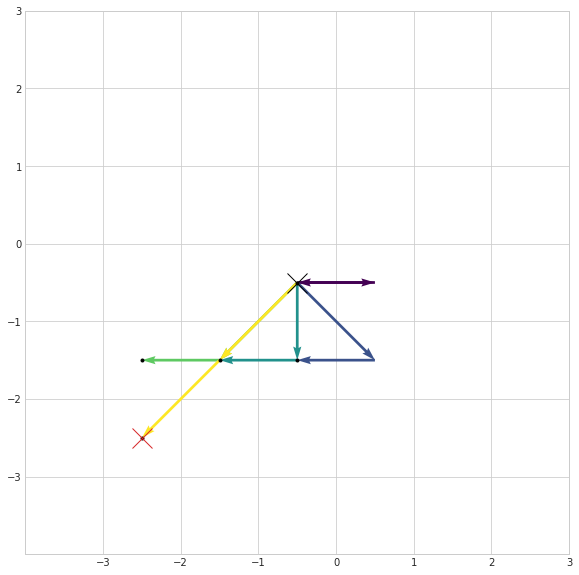

In [21]:
N = len(path)
colors = plt.cm.viridis(np.linspace(0, 1, N))
fig, ax = plt.subplots(figsize=(10, 10))
for i, c in enumerate(path):
    plot_configuration(c, color=colors[i], ax=ax)
start = get_position(config)
# Black X is starting position, red X is target position.
ax.plot(start[0]-0.5, start[1]-0.5, 'x', ms=20, color='k', zorder=11)
ax.plot(point[0]-0.5, point[1]-0.5, 'x', ms=20, color='C3', zorder=11);

(*Exercise:* Try plotting this in the configuration space instead.)

Let's also write a function that will transition from one configuration to another.

In [22]:
def get_path_to_configuration(from_config, to_config):
    path = [from_config]
    config = from_config.copy()
    while config != to_config:
        for i in range(len(config)):
            config = rotate(config, i, get_direction(config[i], to_config[i]))
        path.append(config)
    assert path[-1] == to_config
    return path

Now we can get a path through the entire image by just iterating through each point and extending the path created. Here we create a simple solution for a two-link arm.

In [23]:
n = 2
origin = [(1, 0), (-1, 0)]
points = list(product(range(-n, n + 1), repeat=2))

path = [origin]
for p in points:
    config = path[-1]
    path.extend(get_path_to_point(config, p)[1:])

# Now make sure we end at the "origin" configuration
path.extend(get_path_to_configuration(path[-1], origin)[1:])

len(path)

53

And indeed we see that our path of configutions was positioned at every point in the image and ends at the origin configuration.

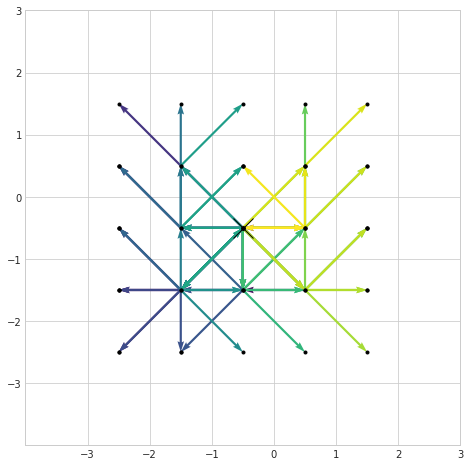

In [24]:
# Plot path
N = len(path)
colors = plt.cm.viridis(np.linspace(0, 1, N))
fig, ax = plt.subplots(figsize=(8, 8))
for i, c in enumerate(path):
    plot_configuration(c, color=colors[i], ax=ax)
start = get_position(path[0])
ax.plot(start[0]-0.5, start[1]-0.5, 'x', ms=20, color='k', zorder=11);

We can also compute the total cost of this solution by mapping the `step_cost` function over successive pairs in the path. We'll use the same test image as before.

In [25]:
# Compute total cost of path over image
def total_cost(path, image):
    return reduce(
        lambda cost, pair: cost + step_cost(pair[0], pair[1], image),
        zip(path[:-1], path[1:]),
        0,
    )


total_cost(path, image)

91.82842712474618

# Create a Submission #

Now let's create a simple solution for the full eight-link arm and create save it as a submission file.

In [26]:
from tqdm import tqdm

origin = [(64, 0), (-32, 0), (-16, 0), (-8, 0), (-4, 0), (-2, 0), (-1, 0), (-1, 0)]
n = origin[0][0] * 2
points = list(product(range(-n, n + 1), repeat=2))

path = [origin]
for p in tqdm(points):
    config = path[-1]
    path.extend(get_path_to_point(config, p)[1:])

# Now make sure we end at the "origin" configuration
path.extend(get_path_to_configuration(path[-1], origin)[1:])

len(path)

100%|██████████| 66049/66049 [00:16<00:00, 4103.49it/s]


133604

And here we compute the total cost of the solution.

In [27]:
image = df_to_image(df_image)

total_cost(path, image)

166305.28453774838

Now let's convert our simple solution into the format expected of a submission file.

In [28]:
def config_to_string(config):
    return ';'.join([' '.join(map(str, vector)) for vector in config])


submission = pd.Series(
    [config_to_string(config) for config in path],
    name="configuration",
)

submission.head()

0     64 0;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0
1    64 -1;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0
2    64 -2;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0
3    64 -3;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0
4    64 -4;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0
Name: configuration, dtype: object

In [29]:
submission.to_csv('submission.csv', index=False)

Feel free to copy any of the code in this notebook for your own solutions. We're looking forward to seeing what you come up with!